In [2]:
%matplotlib inline

from deap import base, creator, tools, algorithms
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing as preproc, datasets, linear_model
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr

toolb = base.Toolbox()
pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)
plt.style.use('ggplot')

# Data Preprocessing

In [3]:
# Note: chart names could occasionally change on blockchain.info
URL = 'https://blockchain.info/charts/%s?timespan=all&format=csv'
CHARTS = ['market-price',
          'market-cap', 
          'transaction-fees-usd', 
          'n-transactions', 
          'n-unique-addresses', 
          'n-transactions-per-block',
          'n-orphaned-blocks',
          'output-volume',
          'estimated-transaction-volume-usd',
          'trade-volume',
          'tx-trade-ratio',
          'cost-per-transaction',
          'hash-rate',
          'difficulty',
          'miners-revenue',
          'median-confirmation-time',
          'bitcoin-days-destroyed',
          'avg-block-size'
         ]

FRAMES = []   # contains everything as DataFrames from charts
FEATURES = [] # standardized DataFrames from charts, excluding market-price

date_parse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

def prep_data(date_from, date_to):
    # Create DataFrame from the market-price
    data = pd.read_csv(URL % CHARTS[0], parse_dates=[0], date_parser = date_parse)
    data.columns = ['date', CHARTS[0]]
    
    df = pd.DataFrame(data)
    df['date'] = df['date'].apply(lambda x: x.date())
    df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = date_from, end = date_to))
    FRAMES.append(df)

    # Create data frames from the rest of the charts
    for chart in CHARTS[1:]:
        data = pd.read_csv(URL % chart, parse_dates=[0], date_parser = date_parse)
        data.columns = ['date', chart]
    
        df = pd.DataFrame(data)
        df['date'] = df['date'].apply(lambda x: x.date())
        df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = date_from, end = date_to))
        FRAMES.append(df)

        # Standardize the values inside the DataFrame
        data_np = df.as_matrix()
        scaler = preproc.StandardScaler().fit(data_np)
        data_np_standard = scaler.transform(data_np)

        # Create a new DataFrame from the standardized values
        df_standard = pd.DataFrame(data=data_np_standard, index=df.index, columns=df.columns)
        FEATURES.append(df_standard)
        
prep_data('1/4/2012', '4/13/2016')

# Linear Regression with R<sup>2</sup> statistic fitness function

In [21]:
def filter_features(mask):
    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun_R2(indiv):
    if(sum(indiv) == 0):
        indiv[0] = 1
    
    filtered_features = filter_features(indiv)
    size = len(filtered_features)
    filtered_features = pd.concat(filtered_features, axis = 1)
    btc_features = pd.DataFrame(filtered_features.values).as_matrix()
    btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing.
    
    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.8*len(btc_features))]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.8*len(btc_target))]
    
    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    #print ('Variance score: %.9f, %d' % (regr.score(btc_X_validation, btc_y_validation), size))
    #plt.scatter(size, regr.score(btc_X_test, btc_y_test), marker='.')
    
    return regr.score(btc_X_validation, btc_y_validation), size

creator.create("FitnessMulti", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti) 

In [28]:
def filter_features(mask):
    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun(model):
    method, metric, indiv = model
    if(sum(indiv) == 0):
        indiv[0] = 1
    
    filtered_features = filter_features(indiv)
    size = len(filtered_features)
    filtered_features = pd.concat(filtered_features, axis = 1)
    btc_features = pd.DataFrame(filtered_features.values).as_matrix()
    btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing.
    
    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.8*len(btc_features))]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.8*len(btc_target))]
    
    # Create the learner

    #regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    method.fit(btc_X_train, btc_y_train)
    #print ('Variance score: %.9f, %d' % (regr.score(btc_X_validation, btc_y_validation), size))
    #plt.scatter(size, regr.score(btc_X_test, btc_y_test), marker='.')
    
    return metric(btc_X_validation, btc_y_validation), size

creator.create("FitnessMulti", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti) 

In [ ]:
gens = 100
indiv_num = 50

toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(FEATURES))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
toolb.register('evaluate', fitness_fun)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

regr = linear_model.LinearRegression()

population = toolb.population()
fits = map (toolb.evaluate, map(lambda x: (regr, regr.score, x), population))
#print(list(fits))
hof = tools.HallOfFame(1)

for fit, ind in zip(fits, population):
    ind.fitness.values = fit

plt.ylim([0.8,1])
fig = plt.gcf()
fig.set_size_inches(5,5)

best = np.ndarray((gens, 1))
top_RMSE = []

for gen in range(gens):
    offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
    hof.update(offspring)
    fits = map (toolb.evaluate, map(lambda x: (regr, regr.score, x), population))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = indiv_num)
    #print(hof[0].fitness.values)
    best[gen] = hof[0].fitness.values[0]
    top_RMSE = hof[0]

x = list(range(0, indiv_num * gens, indiv_num))
plt.plot(x, best)
print ("Selected features: ", list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:])))))

In [238]:
list(map(lambda x: (1,x), [1,2,3,4]))

[(1, 1), (1, 2), (1, 3), (1, 4)]

# NSGAII-MLR with R<sup>2</sup> Statistics

Selected features:  ['market-cap', 'transaction-fees-usd', 'n-transactions-per-block', 'output-volume', 'estimated-transaction-volume-usd', 'trade-volume', 'tx-trade-ratio', 'cost-per-transaction', 'avg-block-size']


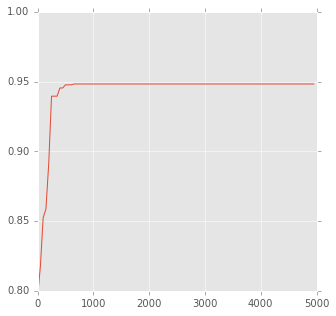

In [25]:
# Concatenate the features in order to group them by date
gens = 100
indiv_num = 50

toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(FEATURES))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
toolb.register('evaluate', fitness_fun_R2)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

population = toolb.population()
fits = map (toolb.evaluate, population)
#print(list(fits))
hof = tools.HallOfFame(1)

for fit, ind in zip(fits, population):
    ind.fitness.values = fit

plt.ylim([0.8,1])
fig = plt.gcf()
fig.set_size_inches(5,5)

best = np.ndarray((gens, 1))
top_RMSE = []

for gen in range(gens):
    offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
    hof.update(offspring)
    fits = map (toolb.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = indiv_num)
    #print(hof[0].fitness.values)
    best[gen] = hof[0].fitness.values[0]
    top_RMSE = hof[0]

x = list(range(0, indiv_num * gens, indiv_num))
plt.plot(x, best)
print ("Selected features: ", list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:])))))

# Linear Regression with RMSE fitness function

In [19]:
def fitness_fun_RMSE(indiv):
    if(sum(indiv) == 0):
        indiv[0] = 1
        
    filtered_features = filter_features(indiv)
    size = len(filtered_features)
    filtered_features = pd.concat(filtered_features, axis = 1)
    btc_features = pd.DataFrame(filtered_features.values).as_matrix()
    btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing. 

    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.8*len(btc_features))]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.8*len(btc_target))]

    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    #print ('RMSE: %.9f, %d' % (math.sqrt(mse(btc_y_validation, regr.predict(btc_X_validation))), size))
    
    return math.sqrt(mse(btc_y_validation, regr.predict(btc_X_validation))), size

creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# NSGAII-MLR with RMSE

Selected features:  ['market-cap', 'n-transactions-per-block', 'output-volume', 'trade-volume', 'cost-per-transaction', 'bitcoin-days-destroyed', 'avg-block-size']


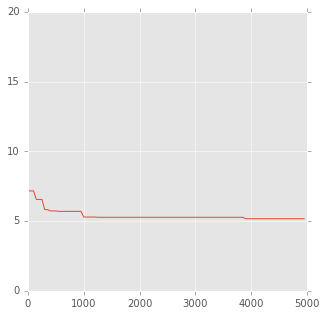

In [20]:
# Concatenate the features in order to group them by date
gens = 100
indiv_num = 50

toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(FEATURES))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
toolb.register('evaluate', fitness_fun_RMSE)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

population = toolb.population()
fits = map (toolb.evaluate, population)
hof = tools.HallOfFame(1)

for fit, ind in zip(fits, population):
    ind.fitness.values = fit

plt.ylim([0,20])
fig = plt.gcf()
fig.set_size_inches(5,5)

best = np.ndarray((gens, 1))
top_R2 = []

for gen in range(gens):
    offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
    hof.update(offspring)
    fits = map (toolb.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = indiv_num)
    #print(hof[0].fitness.values)
    best[gen] = hof[0].fitness.values[0]
    top_R2 = hof[0]

x = list(range(0, indiv_num * gens, indiv_num))
plt.plot(x, best)
print ("Selected features: ", list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:])))))

# Visualizing the actual and predicted prices 

In [ ]:
#for f in frames:
#    f.plot()
    

#features.plot(figsize = (25,25))


RMSE: 22.754526505
Variance score: 0.918056617


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and wil

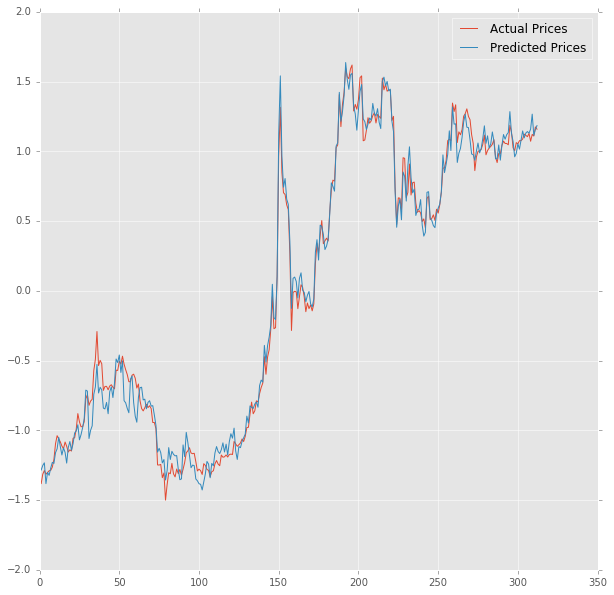

In [226]:
selected = map(lambda t: t[0] and t[1], zip(top_R2, top_RMSE))

filtered_features = filter_features(list(selected))
filtered_features = pd.concat(filtered_features, axis = 1)
btc_features = pd.DataFrame(filtered_features.values).as_matrix()
btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()

btc_X_train = btc_features[:int(0.7*len(btc_features))]
btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.8*len(btc_features))]

btc_y_train = btc_target[:int(0.7*len(btc_target))]
btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.8*len(btc_target))]

# Create the learner

regr = linear_model.LinearRegression()

# Train the learner on the training data
# and evaluate the performance by the test data

regr.fit(btc_X_train, btc_y_train)
btc_X_test = btc_features[int(0.8*len(btc_features)):]
btc_y_test = btc_target[int(0.8*len(btc_target)):]
scaler_act = preproc.StandardScaler().fit(btc_y_test)
scaler_pred = preproc.StandardScaler().fit(regr.predict(btc_X_test))
standardized_act = scaler_act.transform(btc_y_test)
standardized_pred = scaler_pred.transform(regr.predict(btc_X_test))

x = list(range(0, len(btc_y_test)))

plt.figure(figsize = (10,10))
plt.plot(x, standardized_act, label = 'Actual Prices')
plt.plot(x, standardized_pred, label = 'Predicted Prices')
plt.legend()

print ('RMSE: %.9f' % (math.sqrt(mse(btc_y_test, regr.predict(btc_X_test)))))
print ('Variance score: %.9f' % (regr.score(btc_X_test, btc_y_test)))

# Price values

In [ ]:
compare_df = pd.DataFrame(data = list(zip(btc_y_test, regr.predict(btc_X_test))), 
                          index = features.index[int(0.7*len(btc_target)):], 
                          columns = ['actual', 'predicted'])
compare_df